## This notebook has functions to trim/fade samples, then to plot them as waveforms(time), spectrums, and spectrograms. The batch processing section handles multiple files, plot types, and folders.
---------------------------------------------------------------

### Imports



In [47]:
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import os
import scipy
from scipy import signal
from datetime import datetime
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

### Constants / Config

In [4]:
TRIM_DURATION_SECONDS = 0.5 # duration to trim each sample to before processing
FADE_DURATION_SECONDS = 0.03  # 30ms fade to be added before processing, after trim.
SAMPLE_RATE = 22050 # samples will be resampled to this on load
N_FFT_MS = 200
HOP_LENGTH_MS = 1

PLOT_HEIGHT = 4  # Height in inches for each plot
PLOT_WIDTH = 12  # Width in inches for all plots
SUBPLOT_SPACING = 0.4

### Utility Function Definitions



In [5]:
def trim(y, sr, start_seconds, end_seconds):
    # Convert start and end times to samples
    start_sample = int(start_seconds * sr)
    end_sample = int(end_seconds * sr)
    
    # Trim the audio
    y = y[start_sample:end_sample]
    
    return y         

In [6]:
def apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS):
    """
    Apply Hann window to the audio signal
    
    Parameters:
    - y: numpy array of audio samples
    - sr: the samplerate
    - FADE_DURATION_SECONDS: length of the window to apply in s
    
    Returns:
    - windowed audio signal
    """
    
    window_samples = int(FADE_DURATION_SECONDS * sr)


    # Create Hann window
    hann_window = np.hanning(window_samples * 2)
    
    # Split window into fade-in and fade-out
    fade_in = hann_window[:window_samples]
    fade_out = hann_window[window_samples:]
    
    # Apply fade-in to the beginning
    y[:window_samples] *= fade_in
    
    # Apply fade-out to the end
    y[-window_samples:] *= fade_out
    
    return y

### Plotting Function Definitions



In [7]:
def plot_spectrogram(y, sr, fig, ax, n_fft_ms, hop_length_ms, y_scale, 
                    amplitude, vmin, vmax, cmap = 'viridis', title=None):
    """Plot a spectrogram with specified frequency and amplitude scaling.

    Parameters:
    -----------
    y : np.ndarray
        Audio signal
    sr : int
        Sample rate in Hz
    fig : matplotlib.figure.Figure
        Figure object for the plot
    ax : matplotlib.axes.Axes
        Axes object to plot on
    n_fft_ms : int
        FFT window size in milliseconds
    hop_length_ms : int
        Number of milliseconds between successive frames
    y_scale : {'linear', 'log'}
        Frequency axis scaling:
        - 'linear': Shows 0-2000 Hz with linear spacing, ticks every 100 Hz
        - 'log': Shows 20-min(20000, sr/2) Hz with logarithmic spacing
    amplitude : {'db', 'linear'}
        Amplitude scaling:
        - 'db': Shows amplitude in decibels, normalized to max
        - 'linear': Shows amplitude normalized to range 0-1
    vmin : float
        Minimum value for color scaling
    vmax : float
        Maximum value for color scaling
    cmap : str, optional
        Matplotlib colormap name (default: 'viridis')
    title : str, optional
        Plot title (default: None). If not provided, describes the scale types.
    """

    
    # Convert ms to samples
    n_fft = int(n_fft_ms * sr / 1000)
    hop_length = int(hop_length_ms * sr / 1000)
    
    # Compute STFT
    D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    
    # Apply amplitude scaling
    if amplitude == 'db':
        D = librosa.amplitude_to_db(D, ref=np.max)  # Reference to max for consistent scaling
        colorbar_format = '%+2.f dB'
    else:
        # Normalize linear amplitude to 0-1 range
        D = D / np.max(np.abs(D))
        colorbar_format = '%.2f'
    
    # Plot spectrogram
    img = librosa.display.specshow(D, y_axis=y_scale, x_axis='time', 
                                 hop_length=hop_length, sr=sr, ax=ax,
                                 cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Configure frequency axis
    ax.tick_params(axis='y', which='minor', left=False)
    nyquist = sr/2
    
    if y_scale == 'linear':
        ax.set_ylim(0, 2000)
        ax.set_yticks(range(0, 2100, 100))
    else:  # log scale
        if nyquist > 20000:
            ax.set_ylim(20, 20000)
            ax.set_yticks([20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000])
        else:
            ax.set_ylim(20, nyquist)
            ax.set_yticks([20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 7000, nyquist])
    
    # Set title
    plot_type = f"{'Linear' if y_scale=='linear' else 'Log'}-freq, {'dB' if amplitude=='db' else 'Linear'}-amplitude"
    ax.set_title(title if title else f"{plot_type} spectrogram", pad=15)
    
    # Add colorbar
    fig.colorbar(img, ax=ax, format=colorbar_format)

In [8]:
def plot_spectrogram_subtraction(y1, y2, sr, fig, ax, n_fft_ms, hop_length_ms, y_scale, amplitude, vmin, vmax, title1, title2, cmap = 'RdBu_r'):

    """Plot a spectrogram with specified frequency and amplitude scaling.
    
    Parameters:
    -----------
    x : np.ndarray
    audio 2
    y : np.ndarray
        Audio signal
    sr : int
        Sample rate in Hz
    fig : matplotlib.figure.Figure
        Figure object for the plot
    ax : matplotlib.axes.Axes
        Axes object to plot on
    n_fft_ms : int, optional
        FFT window size in milliseconds (default: 100)
    hop_length_ms : int, optional
        Number of milliseconds between successive frames (default: 1)
    y_scale : {'linear', 'log'}, optional
        Frequency axis scaling (default: 'linear')
        - 'linear': Shows 0-2000 Hz with linear spacing
        - 'log': Shows 20-20000 Hz with logarithmic spacing
    amplitude : {'db', 'linear'}, optional
        Amplitude scaling (default: 'db')
        - 'db': Shows amplitude in decibels (-80 to 0 dB)
        - 'linear': Shows normalized linear amplitude (0 to 1)
    title : str, optional
        Plot title (default: None)
    """
    
    
    # Convert ms to samples
    n_fft = int(n_fft_ms * sr / 1000)
    hop_length = int(hop_length_ms * sr / 1000)
    
    # Compute STFT
    D1 = np.abs(librosa.stft(y1, n_fft=n_fft, hop_length=hop_length))
    D2 = np.abs(librosa.stft(y2, n_fft=n_fft, hop_length=hop_length))
        
    
    # Apply amplitude scaling
    if amplitude == 'db':
        D = (librosa.amplitude_to_db(D1, ref=np.max) - librosa.amplitude_to_db(D2, ref=np.max))   # Reference to max for consistent scaling
        colorbar_format = '%+2.f dB'
    else:
        # Normalize linear amplitude to 0-1 range
        # D = D / np.max(np.abs(D))
        D = D1 - D2
        colorbar_format = '%.2f'
    
    # Plot spectrogram
    img = librosa.display.specshow(D, y_axis=y_scale, x_axis='time', 
                                 hop_length=hop_length, sr=sr, ax=ax,
                                 cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Configure frequency axis
    ax.tick_params(axis='y', which='minor', left=False)
    nyquist = sr/2
    
    if y_scale == 'linear':
        ax.set_ylim(0, 2000)
        ax.set_yticks(range(0, 2100, 100))
    else:  # log scale
        if nyquist > 20000:
            ax.set_ylim(20, 20000)
            ax.set_yticks([20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000])
        else:
            ax.set_ylim(20, nyquist)
            ax.set_yticks([20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 7000, nyquist])
    
    # Set title
    plot_type = f"{'Linear' if y_scale=='linear' else 'Log'}-freq, {'dB' if amplitude=='db' else 'Linear'}-amplitude"
    ax.set_title(f"Spectral Subtraction: \n {title1} - {title2}", pad=15)
    
    # Add colorbar    
    cbar = fig.colorbar(img, ax=ax, format=colorbar_format)
    
    # Add text at top and bottom of colorbar using the colorbar object
    cbar.ax.text(1.5, 1.1, f'{title1} leads', 
                 ha='left', va='bottom', transform=cbar.ax.transAxes)
    cbar.ax.text(1.5, -0.1, f'{title2} leads', 
                 ha='left', va='top', transform=cbar.ax.transAxes)

    

In [9]:
def plot_spectrum(y, sr, fig, ax, title=None):
    """Plot magnitude spectrum with frequency axis in Hz."""
    
    # Perform FFT and calculate amplitude
    ft = np.fft.rfft(y)  # Already gives just the positive frequencies
    freqs = np.fft.rfftfreq(len(y), 1/sr)  # Frequencies for rfft
    magnitude_spectrum = np.abs(ft)  # No need to slice
    
    # Convert magnitude to decibels
    magnitude_db = librosa.amplitude_to_db(magnitude_spectrum, ref=np.max)
    
    # Plot the spectrum
    img = ax.plot(freqs, magnitude_db)
    
    # Set log scale and ticks
    ax.set_xscale('log')
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.grid(True, which='major', linestyle='-', alpha=0.3)

    if (20000 < (sr/2)):
        ax.set_xlim(20, 20000)
        ticks = [20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)    
    else:
        ax.set_xlim(20, sr/2)
        ticks = [20, 50, 100, 200, 300, 500, 1000, 2000, 5000, sr/2]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks) 

    
    ax.set_ylim(-80, 0)  

    
    # Labels
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude (dB)')
    if title:
        ax.set_title(f"Spectrum: {title}", pad=15) 
    else:
        ax.set_title('Spectrum', pad=15) 



In [10]:
def plot_time(y, sr, fig, ax, color='#1f77b4', title=None):
    """Plot time-domain signal with improved visualization."""
    # Create time axis in seconds
    times = np.arange(len(y)) / sr
    
    # Plot the waveform
    ax.plot(times, y, color, linewidth=0.75)  # Thinner line for better detail
    
    # Set title and labels 
    if title:
        ax.set_title(f"Waveform: {title}", pad=15)    
    else:
        ax.set_title('Waveform', pad=15)    
        
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    
    # Add grid for better readability
    ax.grid(True, alpha=0.2)
    
    # Set y-axis limits symmetrically based on the signal
    max_amp = np.max(np.abs(y))
    ax.set_ylim(-max_amp, max_amp)
    ax.set_xlim(0, times[-1])

    

In [11]:
def plot_csd(x, y, sr, fig, ax1, ax2, title=None):
    """Plot cross-spectral density magnitude and phase with frequency axis in Hz."""
    
    # Compute CSD using scipy.signal
    f, Pxy = signal.csd(x, y, fs=sr, scaling='density', nperseg=4096)
    
    # Plot magnitude spectrum
    ax1.semilogy(f, np.abs(Pxy))
    ax1.set_xscale('log')
    ax1.tick_params(axis='x', which='minor', bottom=False)
    ax1.grid(True, which='major', linestyle='-', alpha=0.3)
    
    # Plot phase spectrum
    ax2.plot(f, np.angle(Pxy, deg=True))  # deg=True converts to degrees
    ax2.set_xscale('log')
    ax2.tick_params(axis='x', which='minor', bottom=False)
    ax2.grid(True, which='major', linestyle='-', alpha=0.3)
    
    # Set frequency limits and ticks
    for ax in [ax1, ax2]:
        if (20000 < (sr/2)):
            ax.set_xlim(20, 20000)
            ticks = [20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000]
        else:
            ax.set_xlim(20, sr/2)
            ticks = [20, 50, 100, 200, 300, 500, 1000, 2000, 5000, sr/2]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)

    # Labels
    ax1.set_ylabel('CSD Magnitude')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Phase (degrees)')
    
    if title:
        ax1.set_title(f"CSD: {title}", pad=15)
    else:
        ax1.set_title('Cross-spectral Density', pad=15)

### Single file run (with example.wav)




In [ ]:
file = 'example.wav'
y, sr = librosa.load(file,sr=22050)
title = os.path.basename(file) 

y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS) 
# Create fig and ax objects
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

plot_spectrogram(y, sr, fig, ax1, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, amplitude='linear', vmin=0, vmax=1, y_scale='linear')
plot_spectrogram(y, sr, fig, ax2, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, amplitude='db', vmin=-60, vmax=0, y_scale='linear')
plot_spectrogram(y, sr, fig, ax3, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, amplitude='linear', vmin=0, vmax=1, y_scale='log')
plot_spectrogram(y, sr, fig, ax4, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, amplitude='db', vmin=-60, vmax=0, y_scale='log')


# plot_spectrum(y, sr, fig, ax3, title=title)
# plot_time(y, sr, fig, ax4, title=title)


plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)


plt.show()
Audio(y, rate=sr)

### Batch processing




##### PDF Option 1: All plot types per audio file in folder

In [27]:


INPUT_FOLDER = './samples/singlenotes/york/sm57/'
OUTPUT_PATH = './PDFs/york/york_notes_sm57.pdf'

# Create output directory if it doesn't exist
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

with PdfPages(OUTPUT_PATH) as pdf:

    # Process all wav files in folder alphabetically
    wav_files = sorted(Path(INPUT_FOLDER).glob('*.wav'))
    for file in wav_files:
        # Load audio
        y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
        title = os.path.basename(file)
        y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
        y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
        
        # Create a figure with six subplots
        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(PLOT_WIDTH, PLOT_HEIGHT * 6))
        
        # Create plots in subplots
        plot_spectrogram(y, sr, fig, ax1, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=0, vmax=1, y_scale='linear', amplitude='linear', title=title)
        plot_spectrogram(y, sr, fig, ax2, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='linear', amplitude='db', title=title)
        plot_spectrogram(y, sr, fig, ax3, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=0, vmax=1, y_scale='log', amplitude='linear', title=title)
        plot_spectrogram(y, sr, fig, ax4, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='log', amplitude='db', title=title)
        plot_spectrum(y, sr, fig, ax5, title=title)
        plot_time(y, sr, fig, ax6, title=title)
        
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### PDF Option 2: Same plot type across multiple files


In [26]:

# Configuration
# Available plot types:
# SPECTROGRAM
# SPECTRUM
# TIME

PLOT_TYPE = 'SPECTROGRAM'
INPUT_FOLDER = './samples/singlenotes/york/sm57/'
OUTPUT_PATH = f'./PDFs/York/Notes/{PLOT_TYPE}_sm57.pdf'
ROWS = 2
COLUMNS = 1
PLOTS_PER_PAGE = ROWS * COLUMNS

# Create output directory if it doesn't exist
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)


with PdfPages(OUTPUT_PATH) as pdf:
    # Create specs page
    
    # Create initial figure
    fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(PLOT_WIDTH, PLOT_HEIGHT * ROWS))
    axes = [axes] if ROWS * COLUMNS == 1 else axes.flatten()
    plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)
    plot_count = 0

    for file in sorted(Path(INPUT_FOLDER).glob('*.wav')):
        # Load audio
        y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
        y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
        y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
        title = os.path.basename(file)
        
        # Make plot based on type
        if PLOT_TYPE == 'SPECTROGRAM':
            plot_spectrogram(y, sr, fig, axes[plot_count], n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='log', amplitude='db', title=title)
        elif PLOT_TYPE == 'SPECTRUM':
            plot_spectrum(y, sr, fig, axes[plot_count], title=title)
        elif PLOT_TYPE == 'TIME':
            plot_time(y, sr, fig, axes[plot_count], title=title)
        
        plot_count += 1
        
        if plot_count == PLOTS_PER_PAGE:
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)
            fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(PLOT_WIDTH, PLOT_HEIGHT * ROWS))
            axes = [axes] if ROWS * COLUMNS == 1 else axes.flatten()
            plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)
            plot_count = 0
    
    if plot_count > 0:
        # Hide empty subplots
        for i in range(plot_count, PLOTS_PER_PAGE):
            axes[i].set_visible(False)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### PDF Option 3: Compare files across folders with same plot type


In [33]:
# Configuration
# Available plot types:
# SPECTROGRAM
# SPECTRUM
# TIME
PLOT_TYPE = 'SPECTROGRAM'
INPUT_FOLDERS = [
   './samples/singlenotes/yamaha/sm57/',
   './samples/singlenotes/york/sm57/',
   # Add more folders here as needed
]
OUTPUT_PATH = f'./PDFs/SingleNoteComparisons/{PLOT_TYPE.lower()}_linearFreq_linear_amp_comparison.pdf'


# Create output directory and get files from all folders
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)
files = [sorted(list(Path(folder).glob('*.wav'))) for folder in INPUT_FOLDERS]
folder_names = [Path(folder).parts[-1] for folder in INPUT_FOLDERS]

with PdfPages(OUTPUT_PATH) as pdf:

    for i in range(max(len(f) for f in files)):
        fig, axes = plt.subplots(len(INPUT_FOLDERS), 1, 
                           figsize=(PLOT_WIDTH, PLOT_HEIGHT * len(INPUT_FOLDERS)))
        axes = [axes] if len(INPUT_FOLDERS) == 1 else axes  # Handle single folder case
        plt.subplots_adjust(hspace=SUBPLOT_SPACING)
        
        for ax, folder_files, name in zip(axes, files, folder_names):
            if i < len(folder_files):
                y, sr = librosa.load(str(folder_files[i]), sr=SAMPLE_RATE)
                y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
                y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
                title = folder_files[i].name
                
                if PLOT_TYPE == 'SPECTROGRAM':
                    plot_spectrogram(y, sr, fig, ax, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=0, vmax=1, y_scale='linear', amplitude='linear', title=title)
                elif PLOT_TYPE == 'SPECTRUM':
                    plot_spectrum(y, sr, fig, ax, title=title)
                elif PLOT_TYPE == 'TIME':
                    plot_time(y, sr, fig, ax, title=title)
            else:
                ax.text(0.5, 0.5, f'No more files in {name} folder', ha='center', va='center')
                ax.set_title(f"{name} (empty)")
        
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### PDF Option 4: plot entire Audio_DEMOS scales

In [ ]:
# Configuration
# Available plot types:
# SPECTROGRAM-LINEAR-FREQ-LINEAR-AMP
# SPECTROGRAM-LINEAR-FREQ-DECIBELS
# SPECTROGRAM-LOG-FREQ-LINEAR-AMP
# SPECTROGRAM-LOG-FREQ-DECIBELS
# SPECTRUM
# TIME
PLOT_TYPE = 'SPECTROGRAM-LOG-FREQ-DECIBELS'
INPUT_FOLDERS = ['AUDIO_DEMOS/sm57']
OUTPUT_PATH = f'./PDFs/ScaleComparisons/sm57/{PLOT_TYPE.lower()}_scale_comparison.pdf'

# Map plot types to SPEC_PARAMS keys
PLOT_TYPE_TO_PARAMS = {
    'SPECTROGRAM-LINEAR-FREQ-LINEAR-AMP': 'linear_freq_linear_amp',
    'SPECTROGRAM-LINEAR-FREQ-DECIBELS': 'linear_freq_decibels',
    'SPECTROGRAM-LOG-FREQ-LINEAR-AMP': 'log_freq_linear_amp',
    'SPECTROGRAM-LOG-FREQ-DECIBELS': 'log_freq_decibels'
}

# Create output directory and get files from all folders
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)
files = [sorted(list(Path(folder).glob('*.wav'))) for folder in INPUT_FOLDERS]
folder_names = [Path(folder).parts[-1] for folder in INPUT_FOLDERS]

with PdfPages(OUTPUT_PATH) as pdf:
    #  grid dimensions 
    n_rows = 2
    n_cols = 1
    plots_per_page = n_rows * n_cols
    
    # Calculate how many pages we need
    total_files = len(files[0])  # Assuming we're using files from the first folder
    n_pages = (total_files + plots_per_page - 1) // plots_per_page
    
    for page in range(n_pages):
        # Create figure with subplots grid
        fig, axes = plt.subplots(n_rows, n_cols, 
                                figsize=(PLOT_WIDTH * n_cols, PLOT_HEIGHT * n_rows))
        axes = axes.flatten()  # Convert 2D array of axes to 1D for easier indexing
        plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=0.3)
        
        # Plot spectrograms for this page
        for idx in range(plots_per_page):
            file_idx = page * plots_per_page + idx
            if file_idx < total_files:
                y, sr = librosa.load(str(files[0][file_idx]), sr=SAMPLE_RATE)
                title = files[0][file_idx].name
                
                if PLOT_TYPE in PLOT_TYPE_TO_PARAMS:
                    plot_spectrogram(y, sr, fig, axes[idx], 
                                   **SPEC_PARAMS[PLOT_TYPE_TO_PARAMS[PLOT_TYPE]], 
                                   title=title)
                elif PLOT_TYPE == 'SPECTRUM':
                    plot_spectrum(y, sr, fig, axes[idx], title=title)
                elif PLOT_TYPE == 'TIME':
                    plot_time(y, sr, fig, axes[idx], title=title)
            else:
                # Hide empty subplots
                axes[idx].set_visible(False)
        
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### Plot Spectrograms & Subtraction of scale files, with note names on x axis 

In [ ]:

FILE1 = 'AUDIO_DEMOS/sm57/yamaha_sm57_chromaticScale.wav'
FILE2 = 'AUDIO_DEMOS/sm57/york_sm57_chromaticScale.wav'

n_rows = 3
n_cols = 1

# Create figure with subplots grid
fig, (ax1, ax2, ax3) = plt.subplots(n_rows, n_cols, figsize=((n_cols * 12), (n_rows * 4)))
plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=0.3)

### load, no need to trim or window these
y1, sr = librosa.load(FILE1, sr=SAMPLE_RATE)
y2, sr = librosa.load(FILE2, sr=SAMPLE_RATE)


plot_spectrogram(y1, sr, fig, ax1, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='linear', amplitude='db', title=Path(FILE1).name)
plot_spectrogram(y2, sr, fig, ax2, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='linear', amplitude='db', title=Path(FILE2).name)
plot_spectrogram_subtraction(y1, y2, sr, fig, ax3, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-40, vmax=40, y_scale='linear', amplitude='db', title1 = 'Yamaha', title2 = 'York')

#########################
#add note ticks on x axis
for ax in [ax1, ax2, ax3]:
    
    # Get rid of 'time' label
    ax.set_xlabel('') 
    
    # Get current x-axis limits
    x_min, x_max = ax.get_xlim()
    
    # Calculate positions for 45 points (44 segments)
    x_positions = np.linspace(x_min, x_max, 45)
    
    # Create list of major tick positions and labels - every 3 notes (0,3,6,9,etc)
    major_tick_positions = [x_positions[i] for i in [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 43]]
    major_tick_labels = ['C1', 'D#1', 'F#1', 'A1', 'C2', 'D#2', 'F#2', 'A2', 'C3', 'D#3', 'F#3', 'A3', 'C4', 'D#4', 'G4']
    
    # Set major ticks
    ax.set_xticks(major_tick_positions)
    ax.set_xticklabels(major_tick_labels)
    
    # Set minor ticks at every position
    ax.set_xticks(x_positions, minor=True)
    
    # Optional: adjust minor tick appearance
    ax.tick_params(axis='x', which='major', length=8)
    ax.tick_params(axis='x', which='minor', length=4) # make minor ticks shorter

#########################
# Show them!

plt.tight_layout()
plt. show()

##### make scale audio


In [ ]:
# Configuration
INPUT_FOLDER = './samples/singlenotes/york/aom5024/'
OUTPUT_PATH = './AUDIO_DEMOS/aom5024/york_aom5024_chromaticScale.wav'

# Create output directory
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

# Get all wav files in the input folder
wav_files = sorted(Path(INPUT_FOLDER).glob('*.wav'))

# List to store processed audio segments
processed_segments = []

for file in wav_files[:44]:
    # Load audio file
    y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
    
    # Trim and apply window (starting without the pre-onset period)
    y = trim(y, sr, 0.02, TRIM_DURATION_SECONDS)
    y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
    
    # Append processed segment to list
    processed_segments.append(y)

# Concatenate all processed segments
concatenated_audio = np.concatenate(processed_segments)

# Write concatenated audio to output file using soundfile
sf.write(OUTPUT_PATH, concatenated_audio, SAMPLE_RATE)


print(f"Concatenated audio saved to {OUTPUT_PATH}")

##### plot Cross Spectral Density

In [ ]:
file1 = 'samples/singlenotes/york/sm57/york_007_F#1_sm57.wav'
file2 = 'samples/singlenotes/york/aom5024/york_007_F#1_aom5024.wav'
file3 = 'samples/singlenotes/yamaha/sm57/yamaha_007_F#1_sm57.wav'

y1, sr = librosa.load(file1,sr=SAMPLE_RATE)
y2, sr = librosa.load(file2,sr=SAMPLE_RATE)
y3, sr = librosa.load(file3,sr=SAMPLE_RATE)
title = os.path.basename(file) 


y1 = trim(y1, sr, 0, TRIM_DURATION_SECONDS)
y2 = trim(y2, sr, 0, TRIM_DURATION_SECONDS)
y3 = trim(y3, sr, 0, TRIM_DURATION_SECONDS)
y1 = apply_hann_window_fades(y1, sr, FADE_DURATION_SECONDS) 
y2 = apply_hann_window_fades(y2, sr, FADE_DURATION_SECONDS) 
y3 = apply_hann_window_fades(y3, sr, FADE_DURATION_SECONDS) 

# Create fig and ax objects
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

plot_csd(y1, y2, SAMPLE_RATE, fig, ax1, ax2, "York SM57 vs AOM5024")
plot_csd(y1, y3, SAMPLE_RATE, fig, ax3, ax4, "York vs Yamaha SM57")



# plot_spectrum(y, sr, fig, ax3, title=title)
# plot_time(y, sr, fig, ax4, title=title)
plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)
plt.show()



##### Plot Coherence


In [ ]:
##### Plot Coherence
def align_signals(x, y, max_shift_ms=5):
    # Make sure signals are same length
    min_length = min(len(x), len(y))
    x = x[:min_length]
    y = y[:min_length]
    
    # Normalize signals
    x = x / np.max(np.abs(x))
    y = y / np.max(np.abs(y))
    
    # Calculate maximum sample shift from ms
    max_shift = int(max_shift_ms * SAMPLE_RATE / 1000)
    
    # Get correlation only for small window of lags
    correlation = signal.correlate(x, y, mode='same')
    lags = signal.correlation_lags(len(x), len(y), mode='same')
    
    # Only consider lags within our max shift window
    valid_lags = (lags >= -max_shift) & (lags <= max_shift)
    lag = lags[valid_lags][np.argmax(correlation[valid_lags])]
    
    # Align with zero padding to keep length
    if lag > 0:
        y = np.pad(y, (lag, 0))[:len(x)]
    else:
        y = np.pad(y, (0, -lag))[-len(x):]
    
    return x, y, lag

# Align both pairs
y1_aligned, y2_aligned, lag1 = align_signals(y1, y2)
y1_aligned2, y3_aligned, lag2 = align_signals(y1, y3)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

# Plot first pair aligned waveforms
t = np.arange(len(y1_aligned)) / SAMPLE_RATE
ax1.plot(t, y1_aligned, label='York SM57')
ax1.plot(t, y2_aligned, label='York AOM5024')
ax1.set_title(f'Aligned Waveforms (SM57 vs AOM5024) - Offset: {lag1/SAMPLE_RATE*1000:.2f}ms')
ax1.legend()
ax1.grid(True)

# Plot second pair aligned waveforms
t = np.arange(len(y1_aligned2)) / SAMPLE_RATE
ax2.plot(t, y1_aligned2, label='York SM57')
ax2.plot(t, y3_aligned, label='Yamaha SM57')
ax2.set_title(f'Aligned Waveforms (York vs Yamaha) - Offset: {lag2/SAMPLE_RATE*1000:.2f}ms')
ax2.legend()
ax2.grid(True)

# Coherence plots with frequency in Hz
ticks = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]

# York SM57 vs AOM5024 coherence
f, Cxy1 = signal.coherence(y1_aligned, y2_aligned, fs=SAMPLE_RATE, nperseg=4096)
ax3.semilogx(f, Cxy1)
ax3.set_xlim(20, 20000)
ax3.grid(True)
ax3.set_ylabel('Coherence')
ax3.set_title('Coherence: York SM57 vs AOM5024')
ax3.set_xticks(ticks)
ax3.set_xticklabels([str(x) for x in ticks])

# York vs Yamaha coherence
f, Cxy2 = signal.coherence(y1_aligned2, y3_aligned, fs=SAMPLE_RATE, nperseg=4096)
ax4.semilogx(f, Cxy2)
ax4.set_xlim(20, 20000)
ax4.grid(True)
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Coherence')
ax4.set_title('Coherence: York vs Yamaha (SM57)')
ax4.set_xticks(ticks)
ax4.set_xticklabels([str(x) for x in ticks])

plt.tight_layout()
plt.show()

##### Plot spectrograms and subtractions of individual files (almost same as scales one but with trim and windowing added)

In [ ]:
##### Plot Spectrograms & Subtraction of scale files, with note names on x axis 

FILE1 = 'samples/singlenotes/yamaha/sm57/yamaha_037_C4_sm57.wav'
FILE2 = 'samples/singlenotes/york/sm57/york_037_C4_sm57.wav'

n_rows = 3
n_cols = 1

# Create figure with subplots grid
fig, (ax1, ax2, ax3) = plt.subplots(n_rows, n_cols, figsize=((n_cols * 12), (n_rows * 5)))
plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=0.3)

### load, no need to trim or window these
y1, sr = librosa.load(FILE1, sr=SAMPLE_RATE)
y2, sr = librosa.load(FILE2, sr=SAMPLE_RATE)


y1 = trim(y1, sr, 0, TRIM_DURATION_SECONDS)
y1 = apply_hann_window_fades(y1, sr, FADE_DURATION_SECONDS)

y2 = trim(y2, sr, 0, TRIM_DURATION_SECONDS)
y2 = apply_hann_window_fades(y2, sr, FADE_DURATION_SECONDS)


plot_spectrogram(y1, sr, fig, ax1, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='linear', amplitude='db', title=Path(FILE1).name)
plot_spectrogram(y2, sr, fig, ax2, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS, vmin=-80, vmax=0, y_scale='linear', amplitude='db', title=Path(FILE2).name)
plot_spectrogram_subtraction(y1, y2, sr, fig, ax3, n_fft_ms=N_FFT_MS, hop_length_ms=HOP_LENGTH_MS,  vmin=-40, vmax=40, y_scale='linear', amplitude='db', title1 = 'Yamaha', title2 = 'York')


plt.tight_layout()
plt. show()

In [ ]:
file1 = 'tuned_yam.wav'
file2 = 'tuned_york.wav'
y1, sr = librosa.load(file1,sr=22050)
y2, sr = librosa.load(file2,sr=22050)


def align_signals(y1, y2):
    
 
   # Get correlation only for small window of lags
   # Get correlation and lags
    correlation = signal.correlate(y1, y2, mode="full")
    lags = signal.correlation_lags(y1.size, y2.size, mode="full")

    # Find zero index
    zero_idx = np.where(lags == 0)[0][0]

    # Look at negative lags only (up to zero)
    negative_correlation = correlation[:zero_idx]
    negative_lags = lags[:zero_idx]

    # Find peaks in the negative side with conditions
    peaks, _ = signal.find_peaks(negative_correlation, 
                                height=np.max(correlation) * 0.5,  # Only peaks above 50% of max correlation
                                distance=50,  # Minimum samples between peaks
                                prominence=0.1)  # Minimum prominence of peaks

    if len(peaks) == 0:
        lag = 0
    else:
        # Take the last peak (closest to zero)
        last_peak_idx = peaks[-1]
        lag = negative_lags[last_peak_idx]


    
    # Align with zero padding to keep length
    if lag > 0:
        y2 = np.pad(y2, (lag, 0))[:len(y1)]
    else:
        y2 = np.pad(y2, (0, -lag))[-len(y1):]
    
    return y1, y2

def plot_time(y, sr, fig, ax, color='#1f77b4', title=None):
    """Plot time-domain signal with improved visualization."""
    # Create time axis in seconds
    times = np.arange(len(y)) / sr
    
    # Plot the waveform
    ax.plot(times, y, color, linewidth=0.75)  # Thinner line for better detail
    
    # Set title and labels 
    if title:
        ax.set_title(f"Waveform: {title}", pad=15)    
    else:
        ax.set_title('Waveform', pad=15)    
        
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    
    # Add grid for better readability
    ax.grid(True, alpha=0.2)
    
    # Set y-axis limits symmetrically based on the signal
    max_amp = np.max(np.abs(y))
    ax.set_ylim(-max_amp, max_amp)
    ax.set_xlim(0, times[-1])

    
y1 = trim(y1, sr, 0, 0.5)


y2 = trim(y2, sr, 0, 0.5)

y1, y2 = align_signals(y1, y2)

# Create fig and ax objects
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

plot_time(y1, sr, fig, ax1, title=title)
plot_time(y2, sr, fig, ax1, color='r', title=title)
subtraction = y2 - y1
plot_time(subtraction, sr, fig, ax2, title=title)
plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)


plt.show()


### Autotune with pyin etc.?

Detected fundamental frequency: 32.8 Hz
detected pitch: C1


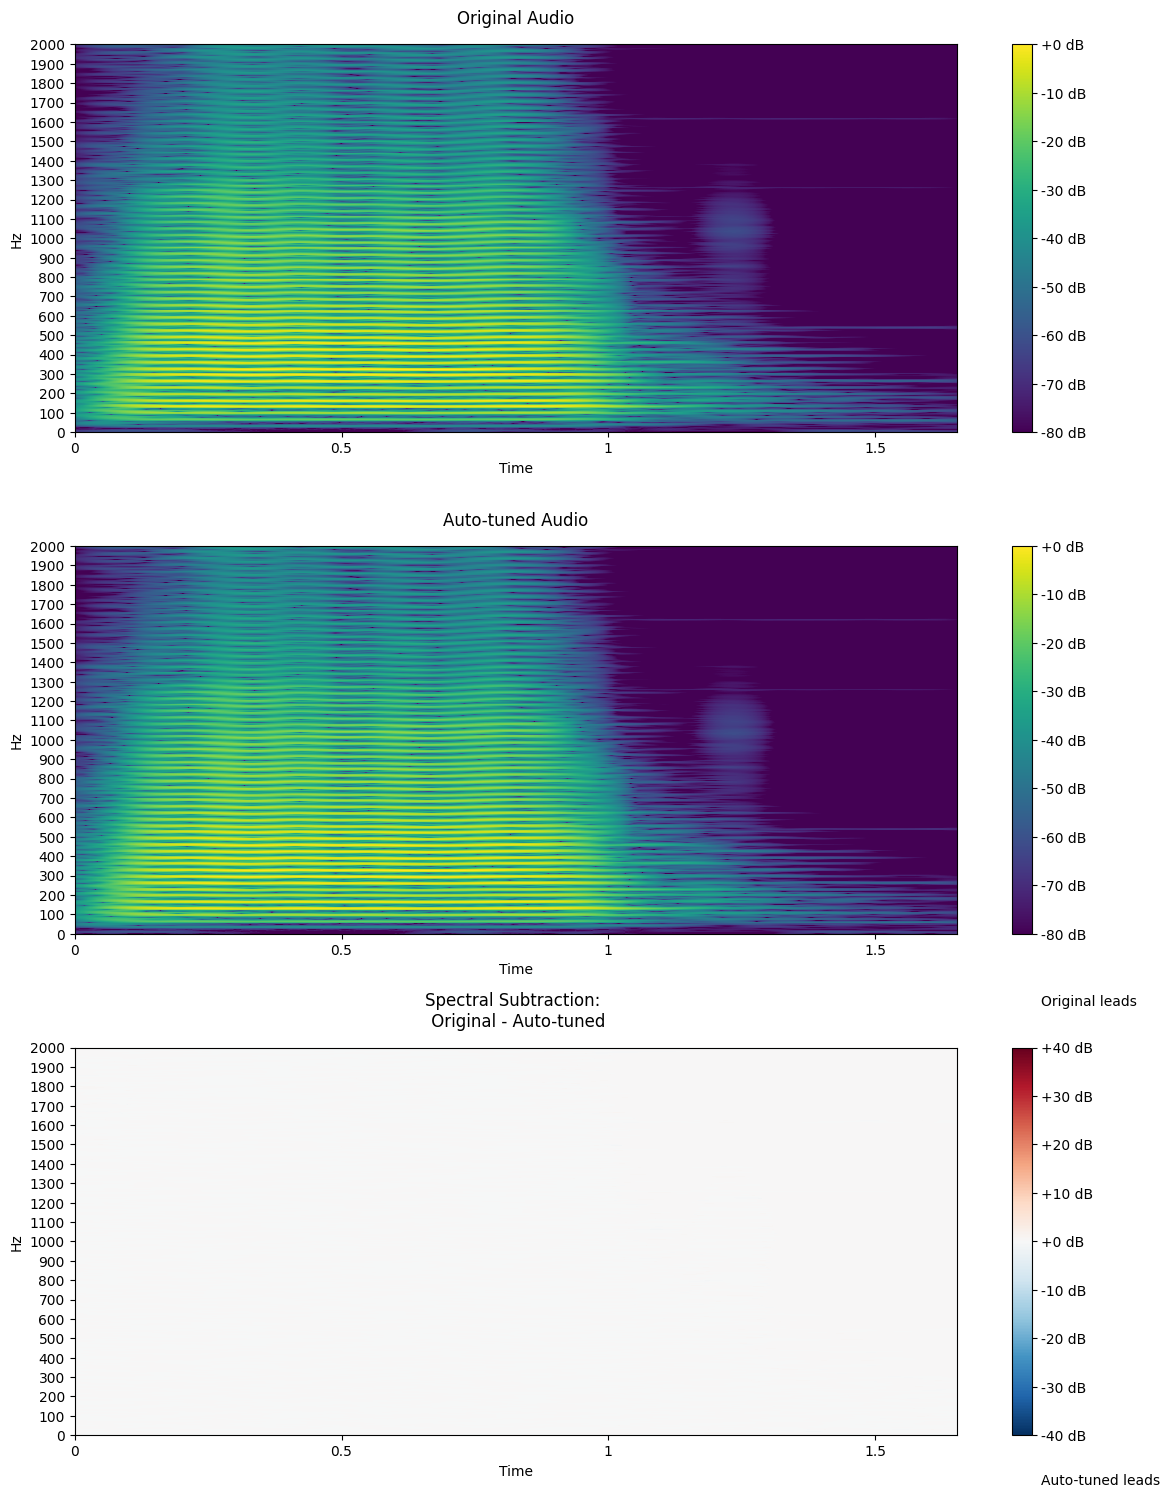

Original audio:


Auto-tuned audio:


In [ ]:
import librosa
import psola
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

# Load audio
y, sr = librosa.load('yamaha_001_C1_sm57.wav')

# Get current pitch
fmin = librosa.note_to_hz('C1')
fmax = librosa.note_to_hz('C5')
f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=sr, fmin=fmin, fmax=fmax)

# Get the median of the detected f0 where it's voiced
median_f0 = np.nanmedian(f0[voiced_flag])
print(f"Detected fundamental frequency: {median_f0:.1f} Hz")
print(f"detected pitch: {librosa.hz_to_note(median_f0)}")

# Create target pitch array with the detected f0
target_pitch = np.full_like(f0, median_f0)

# Pitch shift using PSOLA
pitch_shifted = psola.vocode(y, 
                           sample_rate=int(sr),
                           target_pitch=target_pitch,
                           fmin=fmin,
                           fmax=fmax)

# Create figure with two subplots side by side
plt.figure(figsize=(15, 5))

# Plot original spectrogram
plt.subplot(1, 2, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=8192, hop_length=512)), ref=np.max)
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Original Audio')

# Plot pitch-shifted spectrogram
plt.subplot(1, 2, 2)
D_shifted = librosa.amplitude_to_db(np.abs(librosa.stft(pitch_shifted, n_fft=8192, hop_length=512)), ref=np.max)
librosa.display.specshow(D_shifted, y_axis='log', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Auto-tuned Audio')


plt.tight_layout()
plt.show()

# At the end of your code, add:

# Play both original and pitch-shifted audio
print("Original audio:")
display(Audio(data=y, rate=sr))
print("Auto-tuned audio:")
display(Audio(data=pitch_shifted, rate=sr))
